# Random Forest Classifier

Summary of this classifier: The code below shows the set-up for the random forest classifier. First, the random forest classifier with a PCA preprocessing is applied. Despite tuning of the hyper parameters of the random forest, a lot of variance was present in the accuracy. Then, we performed the random forest classifier with the univariate analysis as preprocessing step. This resulted in a slightly higher mean accuracy, but still with a large variance. We concluded that the random forest classifier is not the optimal choice for our dataset. 

In [4]:
# Import packages

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn

from hn.load_data import load_data

from sklearn import model_selection, metrics, feature_selection, preprocessing, neighbors, decomposition, svm
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.kernel_approximation import RBFSampler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_auc_score

In [5]:
def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    ''' Generates learning curve plots '''

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, val_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, val_scores_mean - val_scores_std,
                         val_scores_mean + val_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, val_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt
    

def data_preprocessing_pca(X_train, X_validation):
    ''' Data preprocessing: first scaling and then PCA with a optimized number of components '''

    # 1. Scaling 
    scaler = preprocessing.StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_validation_scaled = scaler.transform(X_validation)

    # 2. Principle component analysis
    # Using the cumulative summation of the explained variance, we concluded that in
    # order to retain 95% of the variance 30 components are needed.

    pca = decomposition.PCA(n_components=30)
    pca.fit(X_train_scaled)
    X_train_pca = pca.transform(X_train_scaled)
    X_validation_pca = pca.transform(X_validation_scaled)

    return X_train_pca, X_validation_pca


def data_preprocessing_uni(X_train, y_train, X_validation):
    '''Data preprocessing: first scaling and then univariate analysis'''

    # 1. Scaling 
    scaler = preprocessing.RobustScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    df_X_train_scaled = pd.DataFrame(X_train_scaled)
    X_validation_scaled = scaler.transform(X_validation)
    df_X_validation_scaled = pd.DataFrame(X_validation_scaled)

    bestfeatures = SelectKBest(mutual_info_classif, k=20)
    fit = bestfeatures.fit(df_X_train_scaled, y_train)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(df_X_train_scaled.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    best_features = featureScores.nlargest(20,'Score')['Specs']

    X_train_uni = df_X_train_scaled[best_features]
    X_validation_uni = df_X_validation_scaled[best_features]

    return X_train_uni, X_validation_uni

In [ ]:
# Data loading and application of pca preprocessing 

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of features: {len(data.columns)-1}')
y_labels = data['label']
del data['label']

y = sklearn.preprocessing.label_binarize(y_labels, ['T12', 'T34']) # 0 now stands for T12 and 1 for T34
y = [i[0] for i in y]
y = np.array(y)

cv_4fold = model_selection.StratifiedKFold(n_splits=4, shuffle=True)
split_X_train, split_X_test, split_y_train, split_y_test = train_test_split(data, y,
                                                    stratify=y, 
                                                    test_size=0.2)

# Loop over the folds
num = 0
fig = plt.figure(figsize=(15, 15))
for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
    X_validation = split_X_train.iloc[validation_index]
    y_validation = split_y_train[validation_index]
    X_train = split_X_train.iloc[training_index]
    y_train = split_y_train[training_index]

    # Preprocessing with pca
    X_train_pca, X_validation_pca = data_preprocessing_pca(X_train, X_validation)

    # Random Forest Classification
    # Stratified K-fold Cross validation with k=4
    k = 4
    skf = StratifiedKFold(k, random_state=None) # cv kan ook op None --> geeft default --> 5-fold cross validation

    # Tuning the hyperparameters
    grid_param = {'n_estimators': [10, 50, 100, 200, 400],'criterion': ['gini', 'entropy'],'bootstrap': [True, False]}
    grid_search = GridSearchCV(RandomForestClassifier(), param_grid=grid_param, scoring='roc_auc', cv=skf, n_jobs=-1, verbose=2) 
    grid_search.fit(X_train_pca, y_train)

    best_hyperparameters = grid_search.best_params_

    # Best hyperparameters
    n_estimators = best_hyperparameters.get('n_estimators')
    criterion = best_hyperparameters.get('criterion')
    bootstrap = best_hyperparameters.get('bootstrap')
    print(f'Best number of trees: {(n_estimators)}')
    print(f'Best split quality function: {(criterion)}')
    print(f'Best bootstrap: {(bootstrap)}')
    best_result = grid_search.best_score_

    # Apply classifier with tuned hyperparameters
    classifier = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, bootstrap=bootstrap)
    classifier.fit(X_train_pca, y_train)

    # Calculate accuracy
    classifier_predictions_test = classifier.predict(X_validation_pca)
    accuracy = metrics.accuracy_score(y_validation, classifier_predictions_test)
    print(f'Accuracy: {(accuracy)}')
    print('#'*80)

    # Learning curve
    title = 'Learning curve for Random Forest Classifier'
    ax = fig.add_subplot(2, 2, num + 1)
    plot_learning_curve(classifier, title, X_train_pca, y_train, ax, ylim=(0.3, 1.01), cv=skf)
    num += 1

One can see in the results above, the accuracy is varying a lot between the folds. It can differ from approximately 0.55 to 0.80. It can be concluded that the random forest method with PCA preprocessing is not robust for this dataset.

In the section below, the random forest classifier with univariate analysis as preprocessing is conducted. 


The number of samples: 113
The number of features: 159
Fitting 2 folds for each of 20 candidates, totalling 40 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   12.8s finished
Best number of trees: 50
Best split quality function: entropy
Best bootstrap: True
Accuracy: 0.8695652173913043
################################################################################
Fitting 2 folds for each of 20 candidates, totalling 40 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.4s finished
Best number of trees: 200
Best split quality function: gini
Best bootstrap: True
Accuracy: 0.5652173913043478
################################################################################
Fitting 2 folds for each of 20 candidates, totalling 40 fits
[Parallel(n_jobs=-1)]:

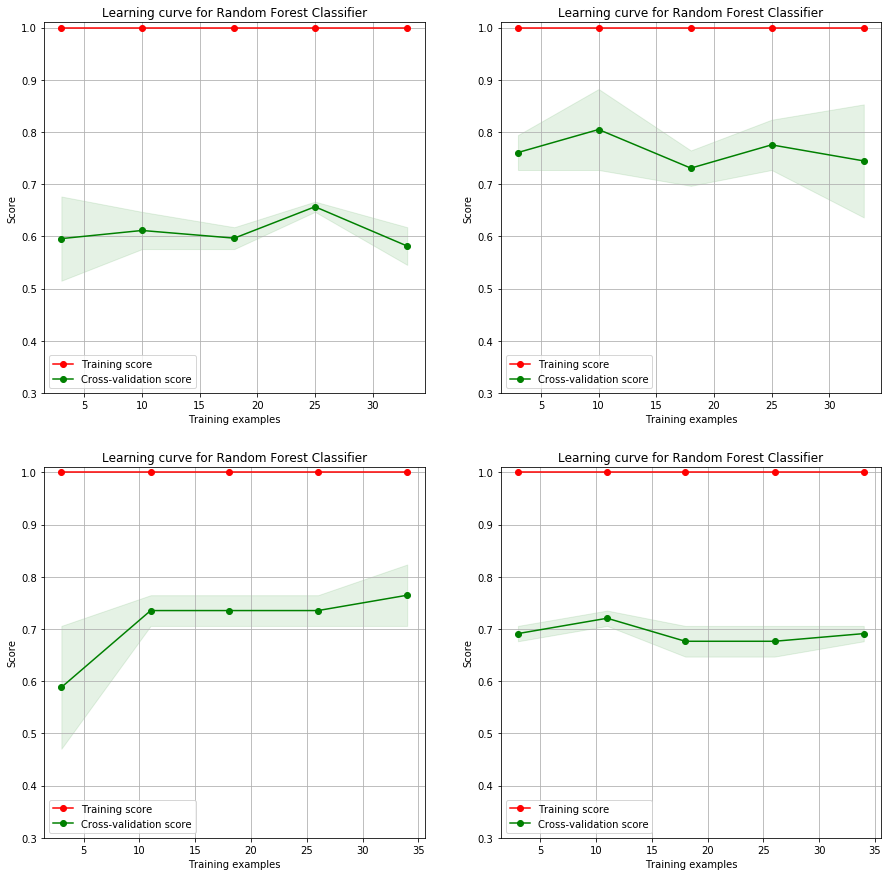

In [8]:
# Data loading and application of univariate preprocessing 

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of features: {len(data.columns)-1}')
y_labels = data['label']
del data['label']

y = sklearn.preprocessing.label_binarize(y_labels, ['T12', 'T34']) # 0 now stands for T12 and 1 for T34
y = [i[0] for i in y]
y = np.array(y)

cv_4fold = model_selection.StratifiedKFold(n_splits=4, shuffle=True)
split_X_train, split_X_test, split_y_train, split_y_test = train_test_split(data, y,
                                                    stratify=y, 
                                                    test_size=0.2)

# Loop over the folds
num = 0
fig = plt.figure(figsize=(15, 15))
for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
    train_scores = []
    test_scores = []
    X_train = split_X_train.iloc[training_index]
    y_train = split_y_train[training_index]
    X_validation = split_X_train.iloc[validation_index]
    y_validation = split_y_train[validation_index]

    # Preprocessing with univariance
    X_train_uni, X_validation_uni = data_preprocessing_uni(X_train, y_train, X_validation)

    # Random Forest Classification
    # Stratified K-fold Cross validation with k = 4 
    k = 4
    skf = StratifiedKFold(k, random_state=None) 

    # Tuning the hyperparameters
    grid_param = {'n_estimators': [10, 50, 100, 200, 400],'criterion': ['gini', 'entropy'],'bootstrap': [True, False]}
    grid_search = GridSearchCV(RandomForestClassifier(), param_grid=grid_param, scoring='roc_auc', cv=skf, n_jobs=-1, verbose=2)   
    grid_search.fit(X_train_uni, y_train)

    best_hyperparameters = grid_search.best_params_

    # Best hyperparameters
    n_estimators = best_hyperparameters.get('n_estimators')
    criterion = best_hyperparameters.get('criterion')
    bootstrap = best_hyperparameters.get('bootstrap')
    print(f'Best number of trees: {(n_estimators)}')
    print(f'Best split quality function: {(criterion)}')
    print(f'Best bootstrap: {(bootstrap)}')
    best_result = grid_search.best_score_  

    # Apply classifier with tuned hyperparameters
    classifier = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, bootstrap=bootstrap)
    classifier.fit(X_train_uni, y_train)

    # Calculate accuracy
    classifier_predictions_test = classifier.predict(X_validation_uni)
    accuracy = metrics.accuracy_score(y_validation, classifier_predictions_test)
    print(f'Accuracy: {(accuracy)}')
    print('#'*80)

    # Learning curve
    title = 'Learning curve for Random Forest Classifier'
    ax = fig.add_subplot(2, 2, num + 1)
    plot_learning_curve(classifier, title, X_train_uni, y_train, ax, ylim=(0.3, 1.01), cv=skf)
    num += 1


As one can see in the results above, the accuracy is varying a lot. Random forest with PCA as preprocessing results in even lower mean accuracy than random forest with univariate analysis as preprocessing. 

The overall conclusion is that the random forest method is not suitable for out dataset.

The number of samples: 113
The number of features: 159
Fitting 2 folds for each of 20 candidates, totalling 40 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.1s finished
Best number of trees: 400
Best split quality function: entropy
Best bootstrap: False
Accuracy: 0.6086956521739131
################################################################################
Fitting 2 folds for each of 20 candidates, totalling 40 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.4s finished
Best number of trees: 400
Best split quality function: entropy
Best bootstrap: True
Accuracy: 0.5652173913043478
################################################################################
Fitting 2 folds for each of 20 candidates, totalling 40 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Pa

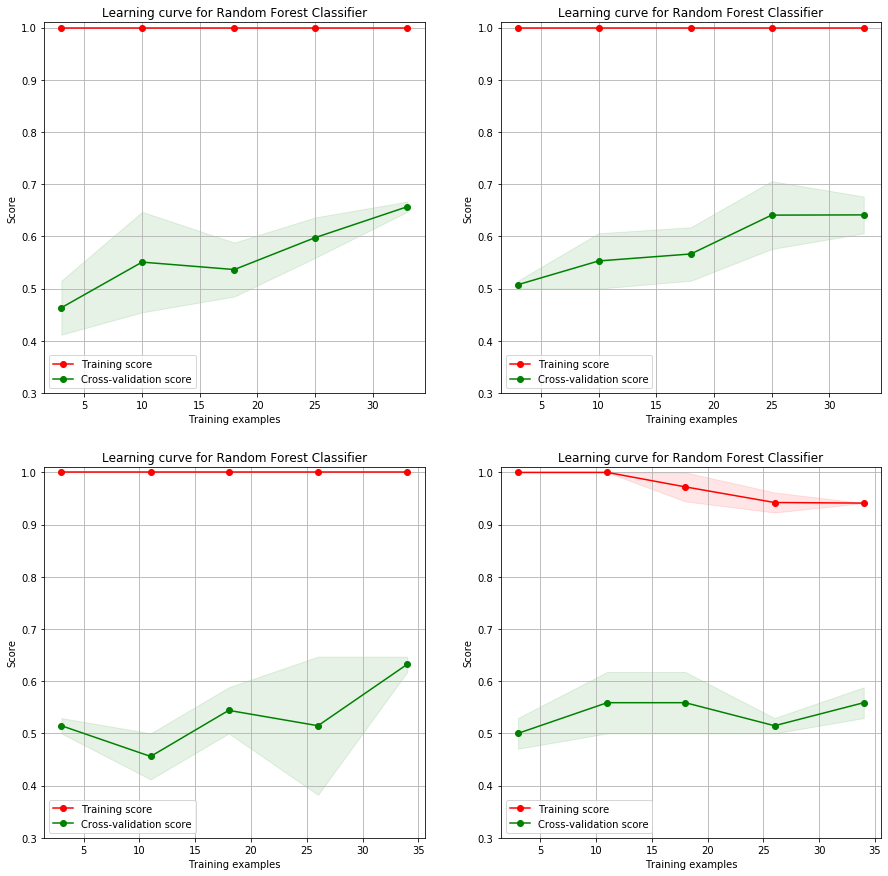

# OUD - niet meeenemen in file

In [10]:
 # OUD
# Data loading and preprocessing

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of features: {len(data.columns)-1}')
y_labels = data['label']
del data['label']

y = sklearn.preprocessing.label_binarize(y_labels, ['T12', 'T34']) # 0 now stands for T12 and 1 for T34
y = [i[0] for i in y]
y = np.array(y)

cv_4fold = model_selection.StratifiedKFold(n_splits=4, shuffle=True)
split_X_train, split_X_test, split_y_train, split_y_test = train_test_split(data, y,
                                                    stratify=y, 
                                                    test_size=0.2)

# Loop over the folds
all_train = []
all_test = []
# for _ in range (0, 2):
#     train_scores = []
#     test_scores = []
    for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
        train_scores = []
        test_scores = []
        X_validation = split_X_train.iloc[validation_index]
        y_validation = split_y_train[validation_index]
        X_train = split_X_train.iloc[training_index]
        y_train = split_y_train[training_index]

        ## Preprocessing 
        X_train_pca, X_validation_pca = data_preprocessing(X_train, y_train, X_validation, y_validation)

        ## RandomForest Classification
        # Stratified K-fold Cross validation
        k = 4
        skf = StratifiedKFold(k, random_state=0) # cv kan ook op None --> geeft default --> 5-fold cross validation

        # Tuning the hyperparameters
        grid_param = {'n_estimators': [10, 50, 100, 200, 400],'criterion': ['gini', 'entropy'],'bootstrap': [True, False]}
        grid_search = GridSearchCV(RandomForestClassifier(),param_grid=grid_param,cv=skf,n_jobs=-1,verbose=2) 
        grid_search.fit(X_train_pca, y_train)

        best_hyperparameters = grid_search.best_params_

        # Best hyperparameters
        n_estimators = best_hyperparameters.get('n_estimators')
        criterion = best_hyperparameters.get('criterion')
        bootstrap = best_hyperparameters.get('bootstrap')
        print(n_estimators)
        print(criterion)
        print(bootstrap)
        best_result = grid_search.best_score_  
        print(best_result)

        # Apply classifier with tuned hyperparameters
        classifier = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, bootstrap=bootstrap)
        classifier.fit(X_train_pca, y_train)
        score_train = classifier.score(X_train_pca, y_train)
        score_test = classifier.score(X_validation_pca, y_validation)
        
        train_scores.append(score_train)
        test_scores.append(score_test)

    all_train.append(train_scores)
    all_test.append(test_scores)

# Create numpy array of scores and calculate the mean and std
all_train = np.array(all_train)
all_test = np.array(all_test)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)

# Plot the mean scores and the std as shading
train_sizes = [0,1,2,3]
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.grid()
ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
        label="Training score")
ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
        label="Test score")

        # # Calculate accuracy
        # classifier_predictions_test = classifier.predict(X_validation_pca)
        # accuracy = metrics.accuracy_score(y_validation, classifier_predictions_test)
        # print(accuracy)
        # print('#'*80)

    # # Learning curves
    # num = 0
    # fig = plt.figure(figsize=(24,8*len(classifier)))
    # for clf in classifier:
    #     title = str(type(clf))
    #     ax = fig.add_subplot(7, 3, num + 1)
    #     plot_learning_curve(clf, title, X_train_pca, y_train, ax, ylim=(0.3, 1.01), cv=skf)
    #     num += 1


IndentationError: unexpected indent (<ipython-input-10-8225f00e42c1>, line 25)

# Oude RandomForest

In [11]:
# Data
from hn.load_data import load_data
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of features: {len(data.columns)-1}')
y_labels = data['label']
del data['label']

y = sklearn.preprocessing.label_binarize(y_labels, ['T12', 'T34']) # 0 now stands for T12 and 1 for T34
y = [i[0] for i in y]
y = np.array(y)

cv_4fold = model_selection.StratifiedKFold(n_splits=4, shuffle=True)
split_X_train, split_X_test, split_y_train, split_y_test = train_test_split(data, y,
                                                    stratify=y, 
                                                    test_size=0.2)
from sklearn.linear_model import LogisticRegression

# Loop over the folds
for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
    X_validation = split_X_train.iloc[validation_index]
    y_validation = split_y_train[validation_index]
    X_train = split_X_train.iloc[training_index]
    y_train = split_y_train[training_index]
    #print(f'Validation size in current fold = {len(X_validation)}')

    scaler = preprocessing.StandardScaler()
    # scaler = preprocessing.MinMaxScaler()
    # scaler = preprocessing.RobustScaler()
    scaler.fit(X_train)
    X_test_scaled = scaler.transform(X_validation)
    X_train_scaled = scaler.transform(X_train)
    #apply preprocessing

    n_selected_features = 10
    n_samples = len(X_train.index)
    n_components = min(n_samples, n_selected_features)
    pca = decomposition.PCA(n_components)
    pca.fit(X_train_scaled)
    X_train_pca = pca.transform(X_train_scaled)
    X_validation_pca = pca.transform(X_test_scaled)

The number of samples: 113
The number of features: 159


In the lecture, we have seen that a random forest has a natural form of feature selection and feature importance. Hence, you may use this feature to find out which features have the most predictive value

Opties --> (n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

In opdracht 2.1
n_estimators = kan alles zijn
bootstrap = True False allebei gebruikt
class_weight gevarieerd

Lastly, if you have an imbalance in your dataset, or one class is more important than the other, you may want
to alter the class weigh in the random forest.

In [12]:
# Stratified K-fold Cross validation
k=4 # K-fold
skf = StratifiedKFold(k, random_state=0) 
# cv kan ook op None --> geeft default --> 5-fold cross validation

In [13]:
# Tuning the hyperparameters
grid_param = {'n_estimators': [10, 50, 100, 200, 400],'criterion': ['gini', 'entropy'],'bootstrap': [True, False]}
grid_search=GridSearchCV(RandomForestClassifier(),param_grid=grid_param,cv=skf,n_jobs=-1,verbose=2) 
grid_search.fit(X_train_pca, y_train)

pd.DataFrame(grid_search.cv_results_)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   17.0s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.048258,0.013769,0.004500,0.001658,True,gini,10,"{'bootstrap': True, 'criterion': 'gini', 'n_es...",0.529412,0.941176,0.470588,0.588235,0.632353,0.183087,5
1,0.346003,0.007067,0.017250,0.006869,True,gini,50,"{'bootstrap': True, 'criterion': 'gini', 'n_es...",0.823529,0.823529,0.411765,0.647059,0.676471,0.168958,2
2,0.587985,0.091890,0.033758,0.011578,True,gini,100,"{'bootstrap': True, 'criterion': 'gini', 'n_es...",0.705882,0.705882,0.529412,0.588235,0.632353,0.076414,5
3,1.071230,0.085144,0.067258,0.009195,True,gini,200,"{'bootstrap': True, 'criterion': 'gini', 'n_es...",0.647059,0.705882,0.470588,0.705882,0.632353,0.096433,5
4,2.231223,0.037762,0.125999,0.017598,True,gini,400,"{'bootstrap': True, 'criterion': 'gini', 'n_es...",0.705882,0.705882,0.588235,0.588235,0.647059,0.058824,3
5,0.046247,0.003416,0.004500,0.001117,True,entropy,10,"{'bootstrap': True, 'criterion': 'entropy', 'n...",0.588235,0.647059,0.470588,0.705882,0.602941,0.087001,12
6,0.317747,0.022331,0.021734,0.005296,True,entropy,50,"{'bootstrap': True, 'criterion': 'entropy', 'n...",0.647059,0.705882,0.470588,0.588235,0.602941,0.087001,12
7,0.586244,0.048949,0.029248,0.001489,True,entropy,100,"{'bootstrap': True, 'criterion': 'entropy', 'n...",0.647059,0.647059,0.529412,0.588235,0.602941,0.048774,12
8,1.114726,0.144995,0.052749,0.001904,True,entropy,200,"{'bootstrap': True, 'criterion': 'entropy', 'n...",0.764706,0.823529,0.588235,0.647059,0.705882,0.093008,1
9,2.184715,0.089663,0.128757,0.012282,True,entropy,400,"{'bootstrap': True, 'criterion': 'entropy', 'n...",0.647059,0.647059,0.470588,0.647059,0.602941,0.076414,16


In [14]:
best_hyperparameters = grid_search.best_params_

n_estimators=best_hyperparameters.get('n_estimators')
criterion=best_hyperparameters.get('criterion')
bootstrap=best_hyperparameters.get('bootstrap')
print(n_estimators)
print(criterion)
print(bootstrap)
best_result = grid_search.best_score_  
print(best_result) 

200
entropy
True
0.7058823529411764


In [15]:
classifier = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, bootstrap=bootstrap)
classifier.fit(X_train_pca, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [16]:
classifier_predictions_test=classifier.predict(X_validation_pca)

accuracy=metrics.accuracy_score(y_validation, classifier_predictions_test)
print(accuracy)


0.6818181818181818
